# Linear Regression and Tests

The purspose of this notebook is to have a template to guide us through all the necessary tests to be done for a Linear Regression model.

We will use statsmodels as our working library since it has all the tests needed already integrated, as opposed to sklearn, that is more practical to actually create a model.

You can test you model using statsmodels first and then create it using sklearn. That is up to you.

Here we will see:

1. Run a model.
2. Test the normality of the residuals.
3. Test the Homocedascity (stability) of the residuals.
4. Outliers in our model.
5. Independence of the residuals.
6. Test for multicolinearity.


# Imports

In [2]:
# Basics
import pandas as pd
import numpy as np

#  Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

# Tests
from statsmodels.stats.diagnostic import lilliefors #Kolmogorov-Smirnov normality test
import scipy.stats as scs # QQ plot
from statsmodels.compat import lzip # Homocedascity test
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.stats.stattools import durbin_watson

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

In [3]:
# Load with pandas
import sklearn.datasets
data_ = sklearn.datasets.load_wine()

In [4]:
# Create dataframe
df = pd.DataFrame(data_.data, columns=data_.feature_names)
df['target'] = data_.target
df.rename(columns={'od280/od315_of_diluted_wines': 'test_diluted_wines'}, inplace=True)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,test_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [5]:
# See the shape
df.shape

(178, 14)

In [6]:
# Nulls
df.isnull().sum()

alcohol                 0
malic_acid              0
ash                     0
alcalinity_of_ash       0
magnesium               0
total_phenols           0
flavanoids              0
nonflavanoid_phenols    0
proanthocyanins         0
color_intensity         0
hue                     0
test_diluted_wines      0
proline                 0
target                  0
dtype: int64

In [7]:
formula = ''
for col in df.columns:
  formula = formula + ' + ' + col

print(formula)

 + alcohol + malic_acid + ash + alcalinity_of_ash + magnesium + total_phenols + flavanoids + nonflavanoid_phenols + proanthocyanins + color_intensity + hue + test_diluted_wines + proline + target


# Creating the Model

We will begin with the creation of the model, so we'll have the residuals to test and assess this regression model.

In [8]:
# Regression Model
model = smf.ols('target ~ alcohol + ash + alcalinity_of_ash + total_phenols + flavanoids + nonflavanoid_phenols + color_intensity + hue + test_diluted_wines + proline', data = df).fit()

In [9]:
# Extract the residuals
model_resid = model.resid
model_resid

0      0.193687
1      0.074731
2     -0.057310
3      0.128511
4     -0.572645
         ...   
173    0.221969
174    0.101630
175    0.005574
176    0.114413
177   -0.126262
Length: 178, dtype: float64

# Test Normality of the Residuals

In order to validate a Linear Regression model, your variables don't necessarily need to be normally distributed, but the residuals of the model do.

In [10]:
# Kolmogorov-Smirnov test
_, p = lilliefors(model_resid, dist='norm')
print('Not normal | p-value:' if p < 0.05 else 'Normal | p-value:', p)
print('-------------------------------')

 # Anderson
stat, p3, _ = scs.anderson(model_resid, dist='norm')
print('Anderson:')
print('Not normal | stat:' if stat > p3[2] else 'Normal | stat:', stat, ':: p-value:', p3[2])


Normal | p-value: 0.2
-------------------------------
Anderson:
Normal | stat: 0.35916418199656164 :: p-value: 0.77


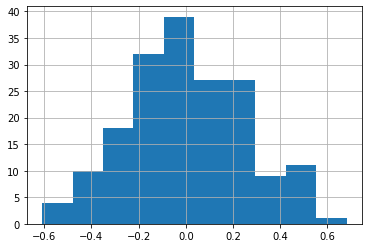

In [11]:
model.resid.hist();

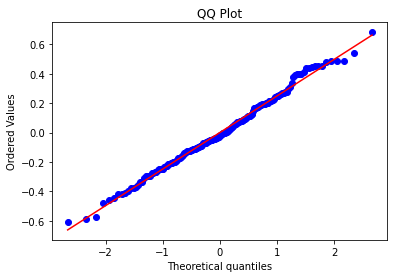

In [12]:
  # QQPlot
  scs.probplot(model_resid, dist='norm', plot=plt)
  plt.title('QQ Plot')
  plt.show()

# Homocedasticity

The model must generate homogeneous results. As the independent variables numbers go up or down, the predictions cannot be lower or higher, but similar among all of the dataset. If the model does not have homogeneous errors, there's bias. 

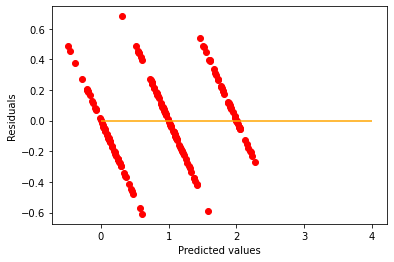

In [13]:
plt.scatter(y= model_resid, x=model.predict(), color='red')
plt.hlines(y=0, xmin=0, xmax=4, color='orange')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

* Ho = Homocedasticity = P > 0.05
* Ha = There's no homocedasticity = p <=0.05

In [14]:
stat, p, f, fp = sms.het_breuschpagan(model_resid, model.model.exog)
print(f'Test stat: {stat}')
print(f'p-Value: {p}')
print(f'F-Value: {f}')
print(f'f_p_value: {fp}')

Test stat: 14.254047656267216
p-Value: 0.16171589669144282
F-Value: 1.45373117596194
f_p_value: 0.16108656286704198


# Residuals Outliers

It is recommended (rule-of-thumb) that the outliers stay between -3 and 3.

In [15]:
outliers = model.outlier_test()

print(outliers.max())
print(outliers.min())

student_resid    3.254315
unadj_p          0.999499
bonf(p)          1.000000
dtype: float64
student_resid   -2.460243
unadj_p          0.001377
bonf(p)          0.245188
dtype: float64


# Residuals Independence

Here, the closer the statistic of the test is to 2, the better. It means that the correlation (r) is near zero and, when plugged in this formula *2 x (1-r)* it will give us 2 as result.

In [16]:
print(f'Test stat: {durbin_watson(model_resid)}')

Test stat: 1.5212847896408088


# Multicollinearity

Multicollinearity can mess up a linear regression model, as when it is present, there is loss of information for the model calculating the OLS. Thus, the more multicollinearity, the less information for the model.

In [17]:
variables = df.drop('target', axis=1)
variables.corr()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,test_diluted_wines,proline
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [19]:
vif = add_constant(variables)
pd.Series([variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])], index=vif.columns)

const                   680.485185
alcohol                   2.460372
malic_acid                1.656647
ash                       2.185448
alcalinity_of_ash         2.238732
magnesium                 1.417855
total_phenols             4.334519
flavanoids                7.029350
nonflavanoid_phenols      1.796380
proanthocyanins           1.975683
color_intensity           3.026304
hue                       2.551447
test_diluted_wines        3.785473
proline                   2.823849
dtype: float64

# Model Analysis

In [22]:
print( model.summary() )

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     147.6
Date:                Fri, 17 Dec 2021   Prob (F-statistic):           1.81e-77
Time:                        22:46:29   Log-Likelihood:                -3.2069
No. Observations:                 178   AIC:                             28.41
Df Residuals:                     167   BIC:                             63.41
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.4742 

In [21]:
df['predictions'] = model.fittedvalues
df.tail(20)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,test_diluted_wines,proline,target,predictions
158,14.34,1.68,2.70,25.0,98.0,2.80,1.31,0.53,2.70,13.000000,0.57,1.96,660.0,2,2.176360
159,13.48,1.67,2.64,22.5,89.0,2.60,1.10,0.52,2.29,11.750000,0.57,1.78,620.0,2,2.207695
160,12.36,3.83,2.38,21.0,88.0,2.30,0.92,0.50,1.04,7.650000,0.56,1.58,520.0,2,2.154876
161,13.69,3.26,2.54,20.0,107.0,1.83,0.56,0.50,0.80,5.880000,0.96,1.82,680.0,2,1.603507
162,12.85,3.27,2.58,22.0,106.0,1.65,0.60,0.60,0.96,5.580000,0.87,2.11,570.0,2,1.704561
163,12.96,3.45,2.35,18.5,106.0,1.39,0.70,0.40,0.94,5.280000,0.68,1.75,675.0,2,1.601658
164,13.78,2.76,2.30,22.0,90.0,1.35,0.68,0.41,1.03,9.580000,0.70,1.68,615.0,2,2.041934
165,13.73,4.36,2.26,22.5,88.0,1.28,0.47,0.52,1.15,6.620000,0.78,1.75,520.0,2,1.921658
166,13.45,3.70,2.60,23.0,111.0,1.70,0.92,0.43,1.46,10.680000,0.85,1.56,695.0,2,2.054358
167,12.82,3.37,2.30,19.5,88.0,1.48,0.66,0.40,0.97,10.260000,0.72,1.75,685.0,2,2.050071
